In [42]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import networkx as nx
from geopy.distance import geodesic

# Retrieving Charging Station Data

### API Request

In [4]:
load_dotenv()

open_charge_map_api_key = os.getenv('OPEN_CHARGE_MAP_API_KEY')
open_charge_map_base_url = 'https://api.openchargemap.io/v3/poi'

params = {
    'output': 'json',
    'countrycode': 'US',
    'latitude': 37.7749, # San Francisco
    'longitude': -122.4149, # San Francisco
    'distance': 50,
    'distanceunit': 'KM',
    'maxresults': 1000,
    'compact': False,   # get detailed data
    'verbose': False,
    'key': open_charge_map_api_key
}

In [5]:
response = requests.get(open_charge_map_base_url, params=params)

if response.status_code == 200:
    data = response.json()
    print(f"Retrieved {len(data)} charging stations.")
    # print(data)
else:
    print(f"Error: {response.status_code}")

Retrieved 1000 charging stations.


### Select Relevant Columns

In [7]:
# flatten data
df = pd.json_normalize(data)

columns = [
    'ID',
    'AddressInfo.Title',
    'AddressInfo.AddressLine1',
    'AddressInfo.Town',
    'AddressInfo.StateOrProvince',
    'AddressInfo.Postcode',
    'AddressInfo.Country.ISOCode',
    'AddressInfo.Latitude',
    'AddressInfo.Longitude',
    'NumberOfPoints',
    'StatusType.IsOperational',
    'Connections'
]

df = df[columns]

df

,ID,AddressInfo.Title,AddressInfo.AddressLine1,AddressInfo.Town,AddressInfo.StateOrProvince,AddressInfo.Postcode,AddressInfo.Country.ISOCode,AddressInfo.Latitude,AddressInfo.Longitude,NumberOfPoints,StatusType.IsOperational,Connections
0,244541,MONOGRAM RES OLUME 2,1401 Mission St,San Francisco,CA,94103,US,37.774966,-122.416038,NaN,True,"[{'ID': 410594, 'ConnectionTypeID': 1, 'Connec..."
1,29744,169 11th St,169 11th St,San Francisco,California,94103,US,37.773568,-122.415794,NaN,NaN,"[{'ID': 32729, 'ConnectionTypeID': 9, 'Connect..."
2,244538,HUDSON PACIFIC 1455 STATION 10,1455 Market Street,San Francisco,CA,94103,US,37.774846,-122.417113,NaN,True,"[{'ID': 410591, 'ConnectionTypeID': 1, 'Connec..."
3,244540,HUDSON PACIFIC 1455 STATION 1,1455 Market Street,San Francisco,CA,94103,US,37.774933,-122.417260,NaN,True,"[{'ID': 410593, 'ConnectionTypeID': 1, 'Connec..."
4,140926,NEMA Apartments,1411 Market Street,San Francisco,CA,94103,US,37.775819,-122.417239,NaN,True,"[{'ID': 196702, 'ConnectionTypeID': 1, 'Connec..."
...,...,...,...,...,...,...,...,...,...,...,...,...
995,262628,ORACLE RWSHORE 5OP-001,520 Oracle Pkwy,Redwood City,CA,94065,US,37.531328,-122.262309,NaN,True,"[{'ID': 445356, 'ConnectionTypeID': 1, 'Connec..."
996,140823,Britannia Point Eden Business Park on Research...,26103 Research Road,Hayward,CA,94545,US,37.625021,-122.127497,NaN,True,"[{'ID': 196564, 'ConnectionTypeID': 1, 'Connec..."
997,27519,CITY OF REDWOOD,399 Marine Pkwy,Redwood City,CA,94065,US,37.531724,-122.259644,NaN,NaN,"[{'ID': 30166, 'ConnectionTypeID': 1, 'Connect..."
998,123978,ORACLE RWSHORE,520 Oracle Pkwy,Redwood City,CA,94065,US,37.530788,-122.261332,NaN,NaN,"[{'ID': 174019, 'ConnectionTypeID': 1, 'Connec..."


### Expand the Connections Field

In [8]:
# expand Connections field which contains list of dictionaries with details about each charger
def expand_connections(row):
    connections = row['Connections']
    connection_data = []
    for conn in connections:
        connection_data.append({
            'Station_ID': row['ID'],
            'ConnectionType': conn.get('ConnectionType', {}).get('Title'),
            'Level': conn.get('Level', {}).get('Title'),
            'Amps': conn.get('Amps'),
            'Voltage': conn.get('Voltage'),
            'PowerKW': conn.get('PowerKW'),
            'CurrentType': conn.get('CurrentType', {}).get('Title'),
        })
    return connection_data

In [9]:
connections_expanded = []
# _ placeholder variable for the first item in the tuple (index of the row)
for _, row in df.iterrows():
    connections_expanded.extend(expand_connections(row))

connections_df = pd.DataFrame(connections_expanded)

### Merge the Connections Back to the Main DataFrame

In [10]:
# merged on ID and Station_ID
merged_df = pd.merge(
    df.drop('Connections', axis=1),
    connections_df,
    left_on='ID',
    right_on='Station_ID',
    how='left'
)

### Handle Availability Information

In [11]:
merged_df['IsOperational'] = merged_df['StatusType.IsOperational']

In [12]:
merged_df

,ID,AddressInfo.Title,AddressInfo.AddressLine1,AddressInfo.Town,AddressInfo.StateOrProvince,AddressInfo.Postcode,AddressInfo.Country.ISOCode,AddressInfo.Latitude,AddressInfo.Longitude,NumberOfPoints,StatusType.IsOperational,Station_ID,ConnectionType,Level,Amps,Voltage,PowerKW,CurrentType,IsOperational
0,244541,MONOGRAM RES OLUME 2,1401 Mission St,San Francisco,CA,94103,US,37.774966,-122.416038,NaN,True,244541.0,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase),True
1,29744,169 11th St,169 11th St,San Francisco,California,94103,US,37.773568,-122.415794,NaN,NaN,29744.0,NEMA 5-20R,Level 1 : Low (Under 2kW),NaN,NaN,NaN,None,NaN
2,244538,HUDSON PACIFIC 1455 STATION 10,1455 Market Street,San Francisco,CA,94103,US,37.774846,-122.417113,NaN,True,244538.0,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase),True
3,244540,HUDSON PACIFIC 1455 STATION 1,1455 Market Street,San Francisco,CA,94103,US,37.774933,-122.417260,NaN,True,244540.0,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase),True
4,140926,NEMA Apartments,1411 Market Street,San Francisco,CA,94103,US,37.775819,-122.417239,NaN,True,140926.0,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,27519,CITY OF REDWOOD,399 Marine Pkwy,Redwood City,CA,94065,US,37.531724,-122.259644,NaN,NaN,27519.0,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.0,AC (Single-Phase),NaN
1216,27519,CITY OF REDWOOD,399 Marine Pkwy,Redwood City,CA,94065,US,37.531724,-122.259644,NaN,NaN,27519.0,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.0,AC (Single-Phase),NaN
1217,27519,CITY OF REDWOOD,399 Marine Pkwy,Redwood City,CA,94065,US,37.531724,-122.259644,NaN,NaN,27519.0,CHAdeMO,Level 2 : Medium (Over 2kW),100.0,400.0,40.0,AC (Single-Phase),NaN
1218,123978,ORACLE RWSHORE,520 Oracle Pkwy,Redwood City,CA,94065,US,37.530788,-122.261332,NaN,NaN,123978.0,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.0,AC (Single-Phase),NaN


### Clean and Organize Data

In [13]:
merged_df.rename(columns={
    'AddressInfo.Title': 'StationName',
    'AddressInfo.AddressLine1': 'Address',
    'AddressInfo.Town': 'City',
    'AddressInfo.StateOrProvince': 'State',
    'AddressInfo.Postcode': 'ZipCode',
    'AddressInfo.Country.ISOCode': 'CountryCode',
    'AddressInfo.Latitude': 'Latitude',
    'AddressInfo.Longitude': 'Longitude',
}, inplace=True)

In [14]:
# reorder columns
merged_df = merged_df[[
    'ID',
    'StationName',
    'Address',
    'City',
    'State',
    'ZipCode',
    'CountryCode',
    'Latitude',
    'Longitude',
    'NumberOfPoints',
    'IsOperational',
    'ConnectionType',
    'Level',
    'Amps',
    'Voltage',
    'PowerKW',
    'CurrentType'
]]

In [15]:
# missing values
merged_df.fillna({
    'ConnectionType': 'Unknown',
    'Level': 'Unknown',
    'Amps': 0,
    'Voltage': 0,
    'PowerKW': 0,
    'CurrentType': 'Unknown'
}, inplace=True)

/var/folders/_b/1njn3wxs55b41_7pgjh8_g700000gn/T/ipykernel_18611/2494975255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.fillna({


In [16]:
merged_df

,ID,StationName,Address,City,State,ZipCode,CountryCode,Latitude,Longitude,NumberOfPoints,IsOperational,ConnectionType,Level,Amps,Voltage,PowerKW,CurrentType
0,244541,MONOGRAM RES OLUME 2,1401 Mission St,San Francisco,CA,94103,US,37.774966,-122.416038,NaN,True,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase)
1,29744,169 11th St,169 11th St,San Francisco,California,94103,US,37.773568,-122.415794,NaN,NaN,NEMA 5-20R,Level 1 : Low (Under 2kW),0.0,0.0,0.0,Unknown
2,244538,HUDSON PACIFIC 1455 STATION 10,1455 Market Street,San Francisco,CA,94103,US,37.774846,-122.417113,NaN,True,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase)
3,244540,HUDSON PACIFIC 1455 STATION 1,1455 Market Street,San Francisco,CA,94103,US,37.774933,-122.417260,NaN,True,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase)
4,140926,NEMA Apartments,1411 Market Street,San Francisco,CA,94103,US,37.775819,-122.417239,NaN,True,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,27519,CITY OF REDWOOD,399 Marine Pkwy,Redwood City,CA,94065,US,37.531724,-122.259644,NaN,NaN,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.0,AC (Single-Phase)
1216,27519,CITY OF REDWOOD,399 Marine Pkwy,Redwood City,CA,94065,US,37.531724,-122.259644,NaN,NaN,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.0,AC (Single-Phase)
1217,27519,CITY OF REDWOOD,399 Marine Pkwy,Redwood City,CA,94065,US,37.531724,-122.259644,NaN,NaN,CHAdeMO,Level 2 : Medium (Over 2kW),100.0,400.0,40.0,AC (Single-Phase)
1218,123978,ORACLE RWSHORE,520 Oracle Pkwy,Redwood City,CA,94065,US,37.530788,-122.261332,NaN,NaN,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.0,AC (Single-Phase)


### Save Data

In [17]:
merged_df.to_csv('charging_stations_data.csv', index=False)


### Data Exploration

In [23]:
num_stations = merged_df['ID'].nunique()

print(f"Total charging stations: {num_stations}")

print("-----------------")

print("Charger types available:")
print(merged_df['ConnectionType'].value_counts())

print("-----------------")

print('Operational Status:')
print(merged_df['IsOperational'].value_counts())

Total charging stations: 1000
-----------------
Charger types available:
ConnectionType
Type 1 (J1772)               839
CCS (Type 1)                 134
CHAdeMO                      105
NEMA 5-20R                    49
NACS / Tesla Supercharger     39
Tesla (Model S/X)             38
Unknown                        9
NEMA 5-15R                     3
NEMA 14-50                     2
SP Inductive                   1
Tesla (Roadster)               1
Name: count, dtype: int64
-----------------
Operational Status:
IsOperational
True     968
False      3
Name: count, dtype: int64


### Additional Cities to Explore

In [24]:
locations = [
    {'city': 'San Francisco', 'lat': 37.7749, 'lon': -122.4194},
    {'city': 'Los Angeles', 'lat': 34.0522, 'lon': -118.2437},
    # Add more locations as needed
]

# Basic Visualizations

In [30]:
charging_station_data = merged_df

charging_station_data.head()

,ID,StationName,Address,City,State,ZipCode,CountryCode,Latitude,Longitude,NumberOfPoints,IsOperational,ConnectionType,Level,Amps,Voltage,PowerKW,CurrentType
0,244541,MONOGRAM RES OLUME 2,1401 Mission St,San Francisco,CA,94103,US,37.774966,-122.416038,NaN,True,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase)
1,29744,169 11th St,169 11th St,San Francisco,California,94103,US,37.773568,-122.415794,NaN,NaN,NEMA 5-20R,Level 1 : Low (Under 2kW),0.0,0.0,0.0,Unknown
2,244538,HUDSON PACIFIC 1455 STATION 10,1455 Market Street,San Francisco,CA,94103,US,37.774846,-122.417113,NaN,True,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase)
3,244540,HUDSON PACIFIC 1455 STATION 1,1455 Market Street,San Francisco,CA,94103,US,37.774933,-122.417260,NaN,True,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase)
4,140926,NEMA Apartments,1411 Market Street,San Francisco,CA,94103,US,37.775819,-122.417239,NaN,True,Type 1 (J1772),Level 2 : Medium (Over 2kW),16.0,230.0,3.7,AC (Single-Phase)


In [34]:
charging_station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1220 non-null   int64  
 1   StationName     1220 non-null   object 
 2   Address         1220 non-null   object 
 3   City            1220 non-null   object 
 4   State           1220 non-null   object 
 5   ZipCode         1220 non-null   object 
 6   CountryCode     1220 non-null   object 
 7   Latitude        1220 non-null   float64
 8   Longitude       1220 non-null   float64
 9   NumberOfPoints  178 non-null    float64
 10  IsOperational   971 non-null    object 
 11  ConnectionType  1220 non-null   object 
 12  Level           1220 non-null   object 
 13  Amps            1220 non-null   float64
 14  Voltage         1220 non-null   float64
 15  PowerKW         1220 non-null   float64
 16  CurrentType     1220 non-null   object 
dtypes: float64(6), int64(1), object(1

In [35]:
charging_station_data.describe()

,ID,Latitude,Longitude,NumberOfPoints,Amps,Voltage,PowerKW
count,1220.000000,1220.000000,1220.000000,178.000000,1220.000000,1220.000000,1220.000000
mean,176094.746721,37.759753,-122.362609,4.876404,15.396721,170.049180,25.691311
std,85426.295212,0.120587,0.102738,6.532527,22.349891,116.880414,60.887035
min,2524.000000,37.511339,-122.697106,1.000000,0.000000,0.000000,0.000000
25%,124158.750000,37.667027,-122.420029,1.000000,0.000000,0.000000,3.000000
50%,223110.500000,37.779131,-122.391280,2.000000,16.000000,230.000000,3.700000
75%,244561.250000,37.812804,-122.279843,5.750000,16.000000,230.000000,7.775000
max,301866.000000,38.025507,-122.088746,40.000000,350.000000,1000.000000,350.000000


### Convert to a GeoDataFrame

In [33]:
# create geometry column from longitude and latitude
geometry = [Point(xy) for xy in zip(charging_station_data['Longitude'], charging_station_data['Latitude'])]

# geodataframe
gdf = gpd.GeoDataFrame(charging_station_data, geometry=geometry)

# coordinate reference system (crs) to WGS84 - standard practice
gdf.crs = 'EPSG:4326'

#### Charger Type Distribution

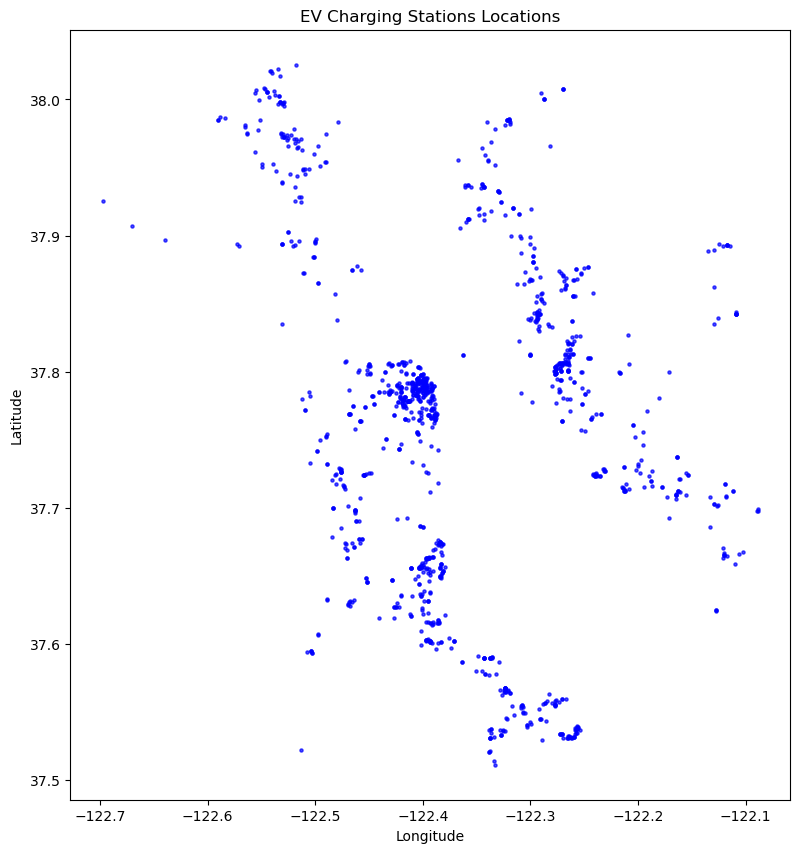

In [36]:
gdf.plot(markersize=5, figsize=(10, 10), alpha=0.7, color='blue')
plt.title('EV Charging Stations Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

This graph shows the spatial distribution of charging stations and helps us identify regions with high densities and areas with low densitions of stations.

#### Charger Type Distribution

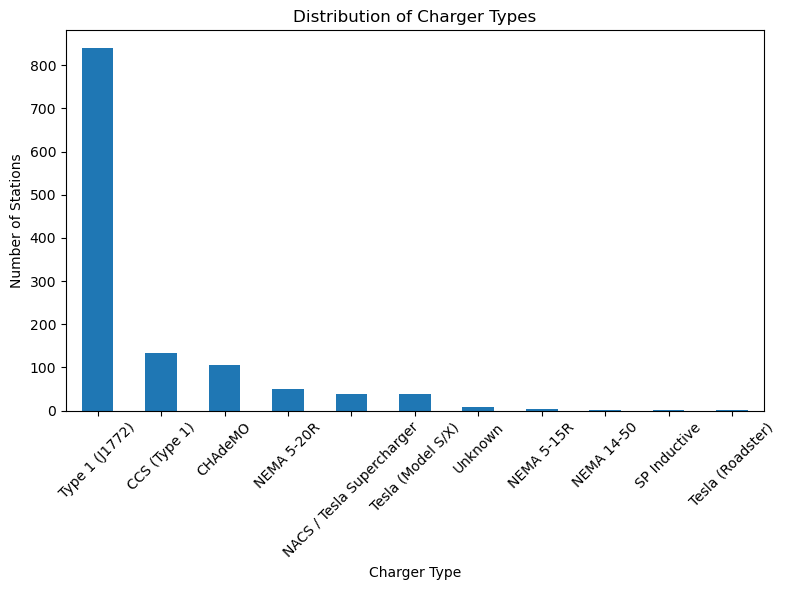

In [37]:
# occurrences of each charger type
charger_counts = charging_station_data['ConnectionType'].value_counts()

# Plot a bar chart
charger_counts.plot(kind='bar', figsize=(8, 6))
plt.title('Distribution of Charger Types')
plt.xlabel('Charger Type')
plt.ylabel('Number of Stations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar graph shows the prevelance of different types of chargers. It gives us insight into which types of chargers are lacking

#### Charger Types on the Map

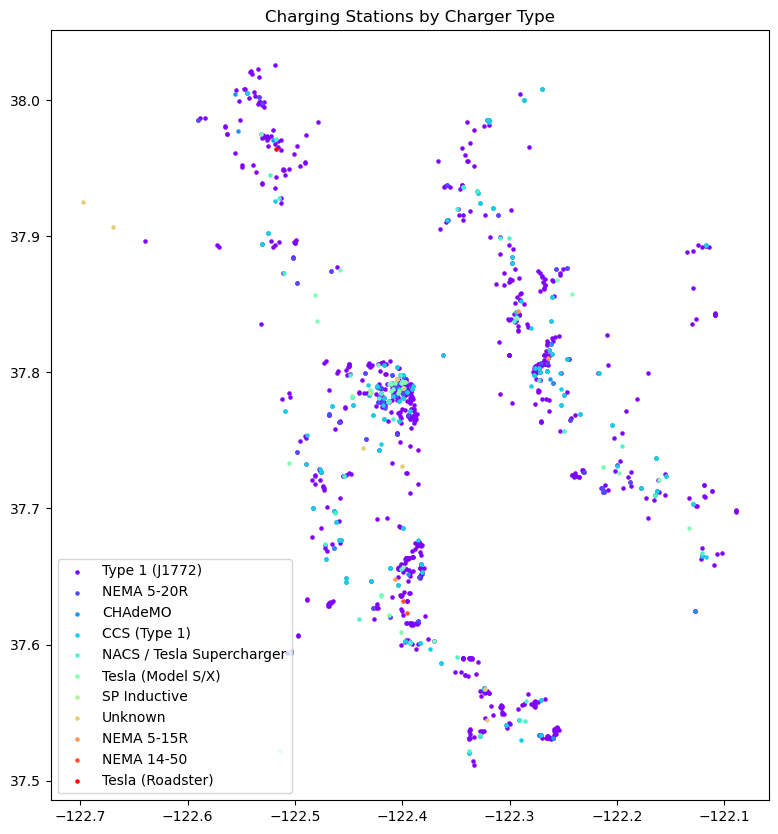

In [39]:
# Get unique charger types
charger_types = charging_station_data['ConnectionType'].unique()

# Define colors for each type
colors = plt.cm.rainbow(np.linspace(0, 1, len(charger_types)))
color_dict = dict(zip(charger_types, colors))

# Plot the stations
fig, ax = plt.subplots(figsize=(10, 10))
for charger_type in charger_types:
    subset = gdf[gdf['ConnectionType'] == charger_type]
    subset.plot(ax=ax, markersize=5, color=color_dict[charger_type], label=charger_type)

plt.legend()
plt.title('Charging Stations by Charger Type')
plt.show()


### Constructing Graph Using Geodesic Distance (Straight-Line Distance)

In [44]:
G = nx.Graph()

for idx, row in gdf.iterrows():
    G.add_node(row['ID'], pos=(row['Longitude'], row['Latitude']))

### Distance Between Stations and Add Edges

In [46]:
def calculate_distance(lat, lon):
    return geodesic(lat, lon).kilometers

In [47]:
# adding edges based on geodesic distance (connect each node to its k nearest neighbors)
k = 3
for idx1, row1 in gdf.iterrows():
    # list to store distances to other stations
    distances = []
    for idx2, row2 in gdf.iterrows():
        if idx1 != idx2:
            dist = calculate_distance((row1['Latitude'], row1['Longitude']),
                                      (row2['Latitude'], row2['Longitude']))
            distances.append((row2['ID'], dist))
    
    # sort distances and connect to the k nearest neighbors
    distances = sorted(distances, key=lambda x: x[1])[:k]

    for id, distance in distances:
        G.add_edge(row1['ID'], id, weight=distance)

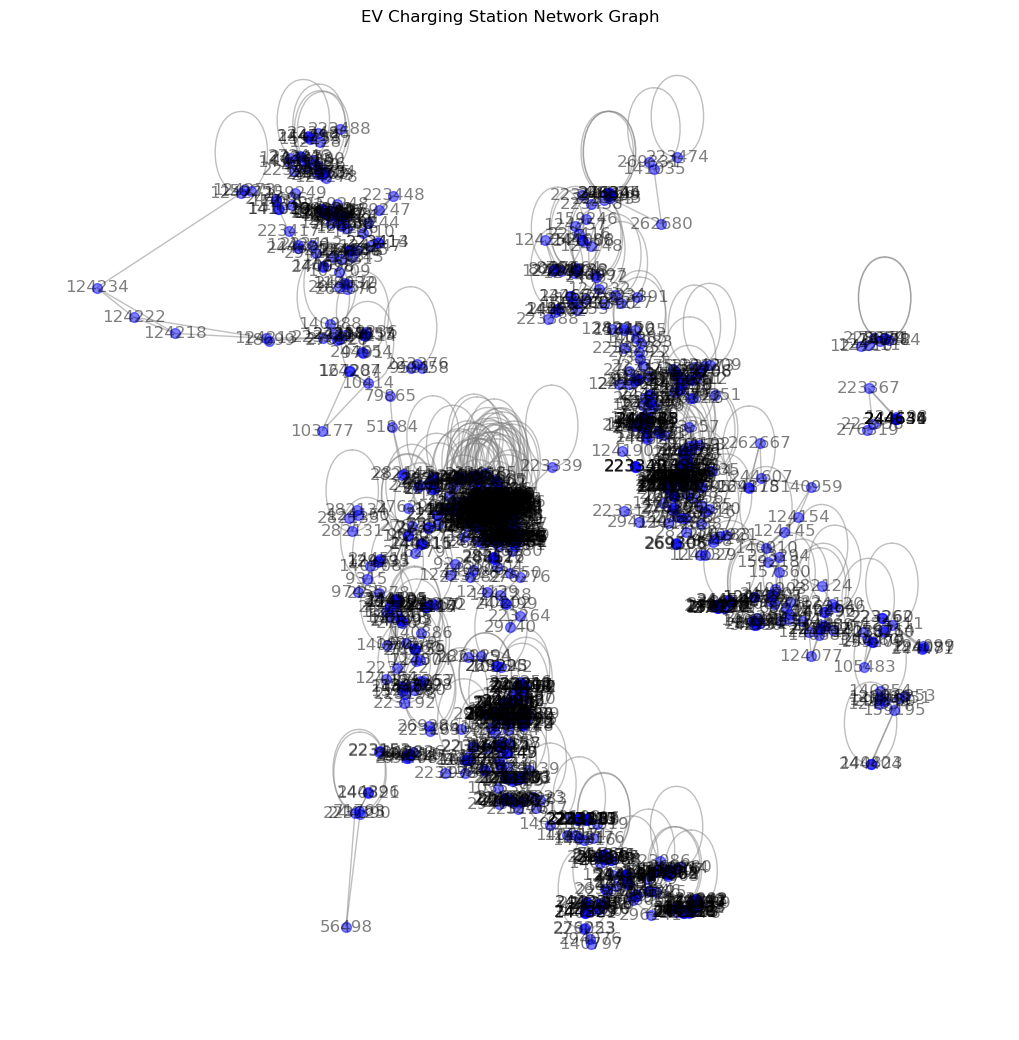

In [51]:
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G.nodes(data=True)}

# Plot graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=50, node_color='blue', edge_color='gray', alpha=0.5, with_labels=True)
plt.title('EV Charging Station Network Graph')
plt.show()

K is the number of edges we give each node which gives us a manageable number of edges, idealy to not overly connect nodes. This visualization helps us observe paths and connections between charging stations. The number of edges we provided for each node can help us analyze the spatial patterns and accessiblity between nearby stations.

This visualization shows us the layout of charging stations in San Francisco, show how well covered some parts of the city are and areas that are more sparse. The edges can tell us which charging stations are easily reachable within a short driving distance from each other. This is useful to identify local hubs or areas where drivers have multiple nearby options.